In [1]:
import numpy as np 
import pandas as pd 


import os, warnings

import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow as tf

In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")


In [3]:
ds_train_ = image_dataset_from_directory(
    '../input/orig-avbcc/train',
    labels='inferred',
    label_mode='binary',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    '../input/orig-avbcc/validation',
    labels='inferred',
    label_mode='binary',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5674 files belonging to 2 classes.
Found 756 files belonging to 2 classes.


In [4]:
input_shape = (224, 224, 3)
classes = 1



model = keras.Sequential([
    layers.InputLayer(input_shape=[224, 224, 3]),
    
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomFlip('vertical'), 
    preprocessing.RandomContrast(0.5), 
    
    tf.keras.applications.ResNet50(
        weights=None, input_shape=input_shape, classes=classes, pooling='avg', include_top=False),
    
    layers.Dense(units=1, activation='sigmoid')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [5]:
def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=2
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01,learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=45,
    verbose=0,
    callbacks=[callback]
)

Epoch 1/45

Epoch 00001: LearningRateScheduler reducing learning rate to 0.004999999888241291.
89/89 - 96s - loss: 0.4201 - binary_accuracy: 0.8109 - val_loss: 0.9056 - val_binary_accuracy: 0.5106
Epoch 2/45

Epoch 00002: LearningRateScheduler reducing learning rate to 0.004999999888241291.
89/89 - 37s - loss: 0.2826 - binary_accuracy: 0.8911 - val_loss: 0.4713 - val_binary_accuracy: 0.7950
Epoch 3/45

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004999999888241291.
89/89 - 37s - loss: 0.2161 - binary_accuracy: 0.9166 - val_loss: 0.4592 - val_binary_accuracy: 0.7487
Epoch 4/45

Epoch 00004: LearningRateScheduler reducing learning rate to 0.004999999888241291.
89/89 - 37s - loss: 0.1650 - binary_accuracy: 0.9348 - val_loss: 0.4156 - val_binary_accuracy: 0.8241
Epoch 5/45

Epoch 00005: LearningRateScheduler reducing learning rate to 0.004999999888241291.
89/89 - 37s - loss: 0.1453 - binary_accuracy: 0.9443 - val_loss: 0.1415 - val_binary_accuracy: 0.9497
Epoch 6/45

Epo

avg val loss: 0.20974434572789405
avg val acc: 0.9257495601971945
min val loss: 0.04738737642765045
min val acc: 0.5105820298194885
max val loss: 1.3141173124313354
max val acc: 0.9867724776268005


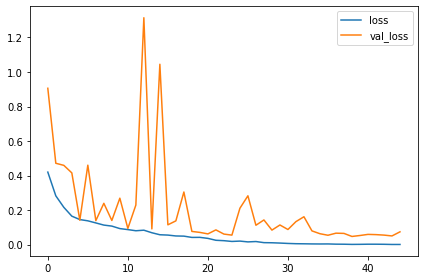

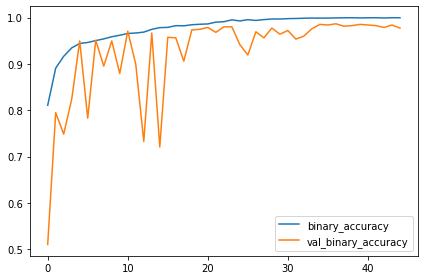

In [7]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(f"avg val loss: {np.mean(history.history['val_loss'])}")

print(f"avg val acc: {np.mean(history.history['val_binary_accuracy'])}")

print(f"min val loss: {np.min(history.history['val_loss'])}")

print(f"min val acc: {np.min(history.history['val_binary_accuracy'])}")

print(f"max val loss: {np.max(history.history['val_loss'])}")

print(f"max val acc: {np.max(history.history['val_binary_accuracy'])}")

model.save('model-rn1.h5')

In [15]:
folder_path = '../input/orig-avbcc/train/av'

model_path = './model-rn1.h5'

img_width, img_height = 224, 224


model = load_model(model_path)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


images = []
for img in os.listdir(folder_path):

    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)



images = np.vstack(images)
classes = model.predict_classes(images, batch_size=10)
c0 = 0
c1 = 0

for x in classes:
    if x[0] == 0:
        c0 += 1
    else:
        c1 += 1

print(f'negative class: {c0}')
print(f'positive class: {c1}')


negative class: 0
positive class: 2912
